In [5]:
# Import Dependencies
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import requests
import gmaps
import os

# Import API key
# from api_keys import g_key


In [8]:
# Import data file
divvy_df = pd.read_csv('resources/Divvy_Trips_2019_Q3.csv')


In [9]:
# Remove null rows (if needed)
divvy_df.dropna()
divvy_df.shape

(1640718, 12)

In [10]:
divvy_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN


In [13]:
divvy_df.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')

In [29]:
top_routes = divvy_df['from_station_name'].value_counts()
total_trips_df = pd.DataFrame({
    'total trips': top_routes
})

total_trips_reduced = total_trips_df.loc[total_trips_df['total trips'] >= 10000]
total_trips_reduced

,total trips
Streeter Dr & Grand Ave,39726
Lake Shore Dr & Monroe St,26309
Lake Shore Dr & North Blvd,21845
Michigan Ave & Oak St,20300
Canal St & Adams St,20176
Clinton St & Madison St,19019
Theater on the Lake,18491
Millennium Park,18337
Clinton St & Washington Blvd,16854
Michigan Ave & Washington St,16073


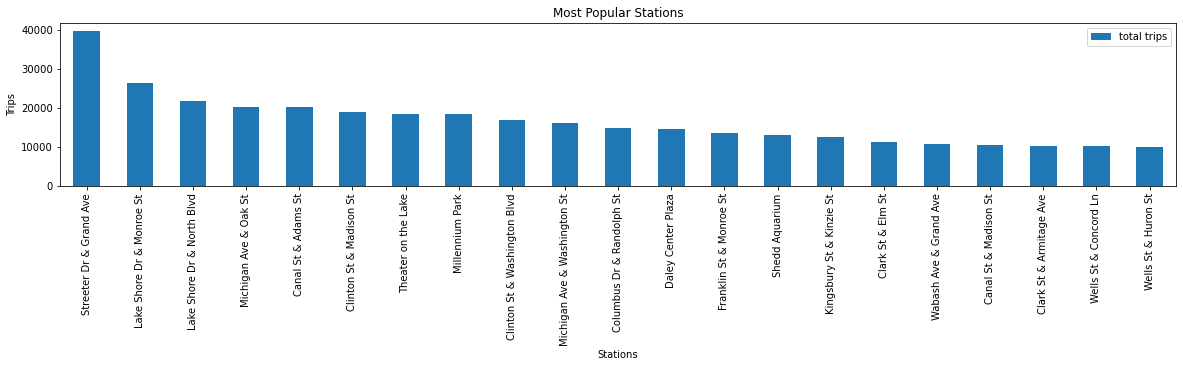

<Figure size 432x288 with 0 Axes>

In [30]:
total_trips_reduced.plot(kind='bar', figsize=(20,3))
plt.title('Most Popular Stations')
plt.xlabel('Stations')
plt.ylabel('Trips')
plt.show()
plt.tight_layout()





In [18]:
divvy_rides = {'from_station': divvy_df['from_station_name'],
               'to_station': divvy_df['to_station_name']
              }

divvy_rides_df = pd.DataFrame(divvy_rides, columns=['from_station', 'to_station'])
dup_to_from = divvy_rides_df.pivot_table(index=['from_station', 'to_station'], aggfunc='size')

from_station          to_station                  
2112 W Peterson Ave   2112 W Peterson Ave              6
                      Broadway & Argyle St             2
                      Broadway & Barry Ave             2
                      Broadway & Berwyn Ave            3
                      Broadway & Granville Ave         6
                                                      ..
Yates Blvd & 75th St  South Shore Dr & 71st St         4
                      South Shore Dr & 74th St         3
                      Stony Island Ave & 82nd St       1
                      Woodlawn Ave & Lake Park Ave     1
                      Yates Blvd & 75th St            21
Length: 101531, dtype: int64

In [19]:
dup_to_from.columns = dup_to_from.droplevel(0)
dup_to_from.columns.name = None
dup_to_from_II = dup_to_from.reset_index()


,from_station,to_station,0
0,2112 W Peterson Ave,2112 W Peterson Ave,6
1,2112 W Peterson Ave,Broadway & Argyle St,2
2,2112 W Peterson Ave,Broadway & Barry Ave,2
3,2112 W Peterson Ave,Broadway & Berwyn Ave,3
4,2112 W Peterson Ave,Broadway & Granville Ave,6
...,...,...,...
101526,Yates Blvd & 75th St,South Shore Dr & 71st St,4
101527,Yates Blvd & 75th St,South Shore Dr & 74th St,3
101528,Yates Blvd & 75th St,Stony Island Ave & 82nd St,1
101529,Yates Blvd & 75th St,Woodlawn Ave & Lake Park Ave,1


In [20]:
to_from_III = dup_to_from_II.rename(columns={'from_station': 'from_station', 'to_station':'to_station', 0:'rides_taken'})
to_from_III

,from_station,to_station,rides_taken
0,2112 W Peterson Ave,2112 W Peterson Ave,6
1,2112 W Peterson Ave,Broadway & Argyle St,2
2,2112 W Peterson Ave,Broadway & Barry Ave,2
3,2112 W Peterson Ave,Broadway & Berwyn Ave,3
4,2112 W Peterson Ave,Broadway & Granville Ave,6
...,...,...,...
101526,Yates Blvd & 75th St,South Shore Dr & 71st St,4
101527,Yates Blvd & 75th St,South Shore Dr & 74th St,3
101528,Yates Blvd & 75th St,Stony Island Ave & 82nd St,1
101529,Yates Blvd & 75th St,Woodlawn Ave & Lake Park Ave,1


In [22]:
to_from_removed_dups = to_from_III[to_from_III['from_station'] != to_from_III['to_station']]


# 25 Most Popular Divvy Routes

In [23]:
most_pop_rides = to_from_removed_dups.loc[to_from_removed_dups.groupby('from_station')['rides_taken'].idxmax()]
most_popular_routes = most_pop_rides.sort_values(ascending=False, by='rides_taken').reset_index(drop=True)
most_popular_reduced = most_popular_routes[0:25]
most_popular_reduced

,from_station,to_station,rides_taken
0,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,5055
1,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,2132
2,Shedd Aquarium,Streeter Dr & Grand Ave,1813
3,Millennium Park,Streeter Dr & Grand Ave,1775
4,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,1703
5,Theater on the Lake,Streeter Dr & Grand Ave,1559
6,Dusable Harbor,Streeter Dr & Grand Ave,1414
7,Canal St & Adams St,Michigan Ave & Washington St,1355
8,Michigan Ave & Oak St,Streeter Dr & Grand Ave,1334
9,Michigan Ave & Washington St,Clinton St & Washington Blvd,1056


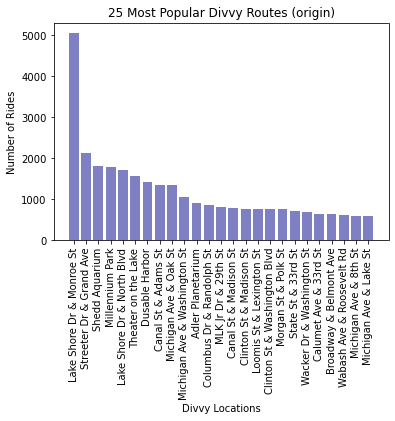

<Figure size 432x288 with 0 Axes>

In [25]:
plt.bar(most_popular_reduced['from_station'], most_popular_reduced['rides_taken'], color='darkblue', alpha=.5, align='center')
plt.xticks(most_popular_reduced['from_station'], rotation='vertical')
plt.title('25 Most Popular Divvy Routes (origin)')
plt.xlabel('Divvy Locations')
plt.ylabel('Number of Rides')
plt.show()
plt.tight_layout()